## Setup Models

In [1]:
!pip install langchain_groq langchain_community -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.2 MB/s eta 0:00:00


In [2]:
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings
import os
from google.colab import userdata

# Setup Groq API key
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

# Setup the LLM using Groq
model = ChatGroq(
    model_name="llama3-70b-8192",  # Llama 3 70B model via Groq
    temperature=0.7
)

# Setup open source embeddings using HuggingFace
embedding = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",  # A popular open source embedding model
    model_kwargs={'device': 'cpu'}  # Use 'cuda' if you have GPU support
)

<ipython-input-2-b73c079dbc27>:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

## 05.02. Engineer prompts for reflection

In [3]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article.
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""


## 05.03. Setup the summary-with-review Agent

In [4]:
!pip install langgraph -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 16.9 MB/s eta 0:00:00


In [5]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class SummaryAgent:

    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug=False):

        self.model=model
        self.summarizer_prompt=summarizer_prompt
        self.reviewer_prompt=reviewer_prompt
        self.debug=debug

        summary_agent_graph=StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer",self.generate_summary)
        summary_agent_graph.add_node("reviewer",self.review_summary)

        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True: "reviewer", False: END }
        )
        summary_agent_graph.add_edge("reviewer", "summarizer")
        summary_agent_graph.set_entry_point("summarizer")

        #Add chat memory
        self.memory=MemorySaver()
        #Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

    def generate_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages

        #invoke the summarizer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"==============\n Generator returned output : {result.content}")
        return { "messages":[result] }

    def review_summary(self, state:SummaryAgentState):
        messages=state["messages"]

        #Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages

        #invoke the reviewer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"*************\n Reviewer returned output : {result.content}")
        return { "messages":[result] }

    def should_continue(self, state:SummaryAgentState):

        total_reviews = len(state["messages"]) / 2

        if self.debug:
            print(f"Iteration number : { total_reviews }")

        #Return if 2 iterations are completed. Each iteration has 2 messages
        if len(state["messages"]) > 4:
            return False
        else:
            return True


## 05.04. Setup the summary-with-review Chatbot

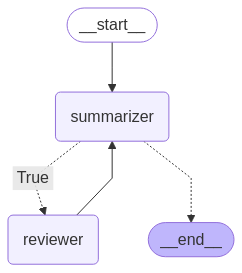

In [6]:
from IPython.display import Image
from langchain_community.document_loaders import PyPDFLoader

#Setup the summary chatbot
summary_chatbot = SummaryAgent(model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=True)

Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())


In [8]:
!pip install pypdf -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 5.1 MB/s eta 0:00:00


In [9]:

#Input file for execution
# Load, chunk and index the contents of the pdf.
loader=PyPDFLoader("EcoSprint_Specification_Document.pdf")
docs = loader.load()

#Pick the first page of the doc as content
source_content=docs[0].page_content.replace("\n"," ")
print(f"Input :==============\n {source_content}\n")

Input :==============
 EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandresponsivedrivingexperience.● Ba

## 05.05. Execute the summary-with-review chatbot

In [10]:
import uuid
#Execute a single request with debug ON
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

messages=[HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)

 Generator returned output : Here is a summary of the EcoSprint Specification Document in under 50 words:

The EcoSprint is a revolutionary electric vehicle designed for efficiency and performance. It features a sleek design, modern interior, and advanced technology, including a high-efficiency electric motor, 250-mile range, and state-of-the-art infotainment and safety systems.
Iteration number : 1.0
*************
 Reviewer returned output : 
 Generator returned output : I'm ready to revise my summary based on your feedback. Please provide your critique or suggestions for improvement.
Iteration number : 2.0
*************
 Reviewer returned output : 
 Generator returned output : Since I didn't receive any feedback, I'll keep my original summary. If you'd like to provide feedback or suggestions, I'd be happy to revise the summary to better meet your needs.
Iteration number : 3.0


In [11]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model,
                               summarizer_prompt,
                               reviewer_prompt,
                               debug=False)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons